In [1]:


import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
# Carrega o dataset como dataframe
df = pd.read_csv('dataset/video_games_2016.csv')

In [45]:
# Remove outliers
Q1 = df['Global_Sales'].quantile(0.00)
Q3 = df['Global_Sales'].quantile(0.98)

df = df[(df['Global_Sales'] >= Q1 ) & (df['Global_Sales'] <= Q3 )]

In [46]:
df["Critic_Score"] = df["Critic_Score"].fillna(0)
df["Critic_Count"] = df["Critic_Count"].fillna(0)
df["Global_Sales"] = df["Global_Sales"].fillna(0)

In [52]:
fdf = df.copy()

grouped = fdf.groupby( "Name" )

a = grouped.agg(
    Genre=("Genre", "first"),
    Developer=("Developer", "first"),
    # Greatest=("Greatest", "first"),
    Publisher=("Publisher", "first"),
    Year_of_Release=("Year_of_Release", "first"),
    Rating=("Rating", "first"),

    Count_Platforms=("Name", "count"),
    Global_Sales=("Global_Sales", "sum"),
    NA_Sales=("NA_Sales", "sum"),
    EU_Sales=("EU_Sales", "sum"),
    JP_Sales=("JP_Sales", "sum"),
    Other_Sales=("Other_Sales", "sum"),
    True_Score=("Critic_Score", lambda x: (x * grouped["Critic_Count"].get_group(x.name)).sum() / grouped["Critic_Count"].get_group(x.name).sum()), 
    # Critic_Score=("Critic_Score", lambda x: x)
).reset_index()

a.sort_values("Count_Platforms", ascending=False).head(4)

/tmp/ipykernel_1310291/3313028063.py:19: RuntimeWarning: invalid value encountered in scalar divide
  True_Score=("Critic_Score", lambda x: (x * grouped["Critic_Count"].get_group(x.name)).sum() / grouped["Critic_Count"].get_group(x.name).sum()),
/tmp/ipykernel_1310291/3313028063.py:5: FutureWarning: Pinning the groupby key to each group in SeriesGroupBy.agg is deprecated, and cases that relied on it will raise in a future version. If your operation requires utilizing the groupby keys, iterate over the groupby object instead.
  a = grouped.agg(


,Name,Genre,Developer,Publisher,Year_of_Release,Rating,Count_Platforms,Global_Sales,NA_Sales,EU_Sales,JP_Sales,Other_Sales,True_Score
6637,Need for Speed: Most Wanted,Racing,EA Canada,Electronic Arts,2012.0,T,11,9.40,4.20,3.88,0.10,1.22,81.780000
5088,LEGO Marvel Super Heroes,Action,TT Games,Warner Bros. Interactive Entertainment,2013.0,E10+,9,9.44,4.31,3.91,0.08,1.11,80.360000
7680,Ratatouille,Action,Asobo Studio,THQ,2007.0,E,9,4.41,2.03,1.35,0.00,0.99,60.446154
5085,LEGO Jurassic World,Action,TT Games,Warner Bros. Interactive Entertainment,2015.0,E10+,8,4.67,2.15,1.91,0.07,0.56,70.276316


/tmp/ipykernel_1310291/2260312164.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


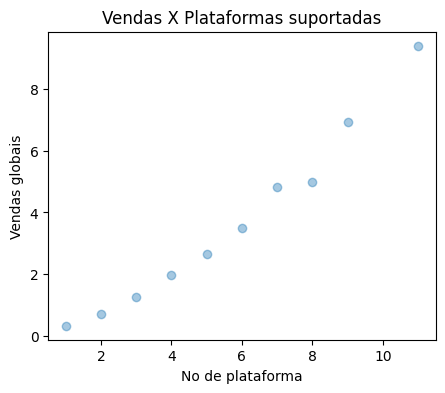

In [38]:
fdf = a
fdf = fdf.groupby("Count_Platforms")["Global_Sales"].mean().reset_index()


plt.figure(figsize=(5, 4))
plt.scatter( 
  fdf['Count_Platforms'],
  fdf['Global_Sales'],

  cmap='viridis',
  alpha=.4
)

plt.ylabel('Vendas globais')
plt.xlabel('No de plataforma')

plt.title('Vendas X Plataformas suportadas')

plt.show()

/tmp/ipykernel_1310291/2880747348.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


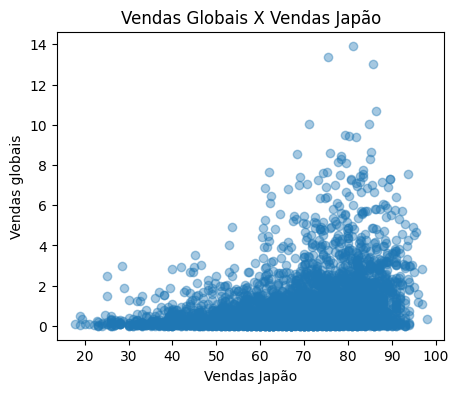

In [39]:

fdf = a

plt.figure(figsize=(5, 4))
plt.scatter( 
  fdf['True_Score'],
  fdf['Global_Sales'],

  cmap='viridis',
  alpha=.4
)

plt.ylabel('Vendas globais')
plt.xlabel('Vendas Japão')

plt.title('Vendas Globais X Vendas Japão')

plt.show()